<a href="https://colab.research.google.com/github/Chanchal2411/Antibiotics_Resistant_Bacteria_Using_Genomic_Data/blob/main/identifying_antibiotic_resistant_bacteria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
nwheeler443_gono_unitigs_path = kagglehub.dataset_download('nwheeler443/gono-unitigs')
shtrausslearning_biopython_genbank_path = kagglehub.dataset_download('shtrausslearning/biopython-genbank')

print('Data source import complete.')


100%|██████████| 2.22M/2.22M [00:00<00:00, 30.2MB/s]

Extracting files...


Data source import complete.


In [ ]:
!pip install biopython

#It’s widely used in computational biology, genomics, and bioinformatics projects.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 24.3 MB/s eta 0:00:00


In [ ]:
!pip install --force-reinstall numpy==1.24.4 catboost==1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 

In [ ]:
# set up environment

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
import time
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import cm
from tqdm import tqdm

from Bio.Seq import Seq

# Sklearn Module
from sklearn.model_selection import KFold,GroupKFold,GridSearchCV,StratifiedKFold
from sklearn.metrics import confusion_matrix,balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer,RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve,ShuffleSplit
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE, SMOTENC, SMOTEN

# Machine Learning Models
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier,CatBoostRegressor
from xgboost import XGBRegressor,XGBClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
import os,warnings;warnings.filterwarnings("ignore")

In [ ]:
# analyzing biological sequences (like DNA, mRNA, and proteins) and visualizing various properties of them.
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter

#combine multiple dictionaries
def dict_sum(dictlist):
  outdic = {}
  for d in dictlist:
    for k in d.keys():
      outdic[k] = 0
  for d in dictlist:
    for k in d.keys():
      outdic[k]+=d[k]
  return outdic

# Class for Sequence Operations
class SQ:

    def __init__ (self, seq=None, seq_type = "DNA"):
        self.seq = seq.upper()
        self.seq_type = seq_type

    # class instance operations
    def __len__(self):
        return len(self.seq)
    def __getitem__(self, n):
        return self.seq[n]
    def __getslice__(self, i, j):
        return self.seq[i:j]
    def __str__(self):
        return self.seq

#Frequency or Count of each nucleotide/amino acid in the sequence
    # Frequency of Sybols
    def freq(self,compare=None,show_id='perc',fheight=None,fwidth=None):

        if(compare is not None):
            if(self.seq_type != compare.seq_type):
                print('sequences are not of same type')
                return None

        c1 = dict(Counter(self.seq))  # abc counter for s1
        if(compare is not None):
            c2 = dict(Counter(compare))  # abc counter for s2

        abc = list(self.abc())
        count = Counter(abc)
        abc_c = dict(Counter({x:0 for x in count}))

#unique symbols (like A, T, G, etc.)
        c_all1 = dict_sum([c1,abc_c])
        if(compare is not None):
            c_all2 = dict_sum([c2,abc_c])

        lst = []
        for i in c_all1.keys():
           if(self.seq_type == 'DNA' or self.seq_type == 'mRNA'):
               lst.append(dic_map('iupac_nucleotide',i))
           elif(self.seq_type == 'PROTEIN'):
               lst.append(dic_map('iupac_amino',i))

        if(compare is not None):
            lst2 = []
            for i in c_all2.keys():
               if(self.seq_type == 'DNA' or self.seq_type == 'mRNA'):
                   lst2.append(dic_map('iupac_nucleotide',i))
               elif(self.seq_type == 'PROTEIN'):
                   lst2.append(dic_map('iupac_amino',i))

        perc = [round(x / len(self.seq),3) for x in [*c_all1.values()]]
        if(show_id is 'perc'):
            show1 = lst; show2 = perc
        elif(show_id is 'count'):
            show1 = lst; show2 = [*c_all1.values()]
        fig = go.Figure(go.Bar(y=show1,x=show2,
                               marker_color='rgb(26, 118, 255)',
                               orientation='h',text=show2,
                               textposition='outside',name='SEQ1'))
        if(compare is not None):
            perc = [round(x / len(compare),3) for x in [*c_all2.values()]]
            if(show_id is 'perc'):
                show1 = lst2; show2 = perc
            elif(show_id is 'count'):
                show1 = lst2; show2 = [*c_all2.values()]
            fig.add_trace(go.Bar(y=show1,x=show2,marker_color='rgb(55, 83, 109)',
                                 orientation='h',text=show2,
                                 textposition='outside',name='SEQ2'))
        fig.update_layout(template='plotly_white',height=fheight,width=fwidth,
                         title=f'<b>{self.seq_type} SEQUENCE CONTENT</b>',
                         font=dict(family='sans-serif',size=12),
                         margin=dict(l=40, r=40, t=50, b=10))
        fig.show()

    # Return % GC Nucleotides - Guanine (G) or Cytosine (C).
    def gc(self):
        if (self.seq_type == "DNA" or self.seq_type == "mRNA"):
            ii = 0
            for s in self.seq:
                if(s in "GCgc"):
                    ii += 1
            return round(ii / len(self.seq),4)
        else:
            return None

    # General Sequence Info
    def get_seq_biotype (self):
        return self.seq_type
    def info(self):
        print (f"SEQ: {self.seq}" +" "+ f"TYPE: {self.seq_type}")

    # Get ABC
    def abc(self):
        if(self.seq_type=="DNA"):
          return "ACGT"
        elif(self.seq_type=="mRNA"):
          return "ACGU"
        elif (self.seq_type=="PROTEIN"):
          return "ACDEFGHIKLMNPQRSTVWY"
        else:
          return None

    # Check Validity
    def validate(self,verbose=False):
        alp = self.abc()
        res = True; i = 0
        while (res and i < len(self.seq)):
            if self.seq[i] not in alp:
                res = False
            else: i += 1
        if(res):
            if(verbose):
                print(f'{self.seq_type} is valid')
            return res
        else:
            if(verbose):
                print(f'{self.seq_type} is invalid')
            return res

    # Transcription
    def transcription(self):
        if (self.seq_type == "DNA"):
            return SQ(self.seq.replace("T","U"), "mRNA")
        else:
            return None

    # Reverse Compliment
    def reverse_comp(self):

        if (self.seq_type != "DNA"):
            print('input not DNA')
            return None

        lst_seq = ['A','T','G','C']
        lst_comp = ['T','A','C','G']

        comp = ''
        for char in self.seq:
            ii=-1
            for c in lst_seq:
                ii+=1
                if(char == c ):
                    comp = lst_comp[ii] + comp

        return SQ(comp, "DNA")

    # Translate
    @staticmethod
    def translate(seq,p0=0):
        seq_aa = ""
        for pos in range(p0,len(seq)-2,3):
            cod = seq[pos:pos+3]
            seq_aa += dic_map(map_id='codon',tid=cod)
        return seq_aa

    '''Get All Possible open reading frames (ORF)'''
    # store all possible collections of amino acid groups
    # in all 6 frames
    def frames(self):
        res = []
        for i in range(0,3):
            res.append(self.translate(self.seq,i))
        rc = self.reverse_comp()
        for i in range(0,3):
            res.append(self.translate(rc,i))
        return res

    '''Computes all possible proteins in an amino acid sequence in reading frame '''
    # using the knowledge that it starts with M and ends with _,
    # filter out rule breaking ORFs
    @staticmethod
    def all_proteins_RF(aa_seq):
        # aa_seq -> converted ORF
        current_prot = []
        proteins = []
        for aa in aa_seq:
            if(aa == "_"):
                if current_prot:
                    for p in current_prot:
                        proteins.append(p)
                    current_prot = []
            else:
                if(aa == "M"):
                    current_prot.append("")
                for i in range(len(current_prot)):
                    current_prot[i] += aa
        return proteins

    '''Computes all possible proteins for all ORF'''
    # and sort them based on size
    def ORF_protein(self, mins = 0):

        # order
        def insert_prot_ord (prot, list_prots):
            i = 0
            while i < len(list_prots) and len(prot) < len(list_prots[i]):
                i += 1
            list_prots.insert(i, prot)

        rfs = self.frames()  # get all ORF conversions
        res = []
        for rf in rfs:
            print(rf)
            prots = self.all_proteins_RF(rf) # return only protein cases
            # additionally sort based on protein size
            for p in prots:
                if len(p) > mins:
                    insert_prot_ord(p, res)
        return res

# Plot Correlation to Target Variable only
def corrMat(df,target='demand',figsize=(9,0.5),ret_id=False):

    corr_mat = df.corr().round(2);shape = corr_mat.shape[0]
    corr_mat = corr_mat.transpose()
    corr = corr_mat.loc[:, df.columns == target].transpose().copy()

    if(ret_id is False):
        f, ax = plt.subplots(figsize=figsize)
        sns.heatmap(corr,vmin=-0.3,vmax=0.3,center=0,
                     cmap=cmap,square=False,lw=2,annot=True,cbar=False)
        plt.title(f'Feature Correlation to {target}')

    if(ret_id):
        return corr

In [ ]:
import kagglehub

# Download the dataset and get its path
nwheeler443_gono_unitigs_path = kagglehub.dataset_download('nwheeler443/gono-unitigs')

In [ ]:
print(nwheeler443_gono_unitigs_path)

/kaggle/input/gono-unitigs


In [ ]:
#Load and align genomic unitig feature data with phenotypic metadata (like antibiotic resistance) from Neisseria gonorrhoeae

import pandas as pd
import numpy as np
import os

''' Align Metadata Target values w/ Unitig File & Compile Feature Matrix '''
class get_unitigs:
    def __init__(self, base_path='/kaggle/input/gono-unitigs', verbose=True):
        self.base_path = base_path
        self.df = pd.read_csv(os.path.join(base_path, 'metadata.csv'), index_col=0)
        self.meta_names = self.df.columns
        self.target_name = None
        self.verbose = verbose
        self.X = None
        self.metadata = None

    def get_case(self, phenotype=None):
        self.target_name = phenotype
        _metadata = self.df

        if self.verbose:
            print(f'Target Antibiotic: {self.target_name}')
            print(f'Metadata df: {_metadata.shape}')

        # Remove samples without target values
        _metadata = _metadata.dropna(subset=[phenotype])
        self.metadata = _metadata.copy()

        if self.verbose:
            print(f'Metadata df after na() removal: {_metadata.shape}')

        _metadata = _metadata[phenotype]
        suffix = '_gwas_filtered_unitigs.Rtab'

        if self.verbose:
            print('\nCombining Metadata & Unitigs')

        # Load unitig file
        unitig_path = os.path.join(self.base_path, phenotype + suffix)
        tdf = pd.read_csv(unitig_path, sep=" ", index_col=0, low_memory=False)
        tdf = tdf.T

        # Align unitig samples with metadata samples
        tdf = tdf[tdf.index.isin(_metadata.index)]
        target = _metadata[_metadata.index.isin(tdf.index)]

        self.X = pd.concat([tdf, target], axis=1)

        if self.verbose:
            print(f'Unitig Matrix (+target): {self.X.shape}')

In [ ]:
case_cip = get_unitigs(base_path='/kaggle/input/gono-unitigs')
display(case_cip.df.T.iloc[:,:7])

Sample_ID,ERR1549286,ERR1549290,ERR1549291,ERR1549287,ERR1549288,ERR1549299,ERR1549292
Year,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0,2015.0
Country,UK,UK,UK,UK,UK,UK,UK
Continent,Europe,Europe,Europe,Europe,Europe,Europe,Europe
Beta.lactamase,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Azithromycin,>256,>256,>256,>256,>256,>256,>256
Ciprofloxacin,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ceftriaxone,0.016,0.004,0.006,0.006,0.008,0.012,0.023
Cefixime,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tetracycline,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Penicillin,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
case_cip = get_unitigs(base_path='/kaggle/input/gono-unitigs')
case_cip.get_case(phenotype='cip_sr')
case_cip.X.iloc[:, :2].head()

Target Antibiotic: cip_sr
Metadata df: (3786, 30)
Metadata df after na() removal: (3088, 30)

Combining Metadata & Unitigs
Unitig Matrix (+target): (3088, 8874)


,ACGTTTATGCCGTTATCGATCCGATAGCCGGT,CATCTGCACCCTGTCGGCACTCGCCGCCTGAACCACCCCGTCCGGACAAGG
SRR1661154,0,0
SRR1661156,0,0
SRR1661157,0,0
SRR1661158,0,0
SRR1661159,0,0


In [ ]:
target = case_cip.X[case_cip.target_name]
print(target[:5])

SRR1661154    0.0
SRR1661156    1.0
SRR1661157    0.0
SRR1661158    0.0
SRR1661159    0.0
Name: cip_sr, dtype: float64


In [ ]:
''' Ciprofloxacin '''
# 8873 Unitigs

case = get_unitigs(base_path='/kaggle/input/gono-unitigs')
case.get_case('cip_sr')
print(case.X[case.target_name].value_counts())

Target Antibiotic: cip_sr
Metadata df: (3786, 30)
Metadata df after na() removal: (3088, 30)

Combining Metadata & Unitigs
Unitig Matrix (+target): (3088, 8874)
cip_sr
0.0    1660
1.0    1428
Name: count, dtype: int64


In [ ]:
''' Azithromycin '''
# 515 unitigs

case = get_unitigs(base_path='/kaggle/input/gono-unitigs')
case.get_case('azm_sr')
print(case.X[case.target_name].value_counts())

Target Antibiotic: azm_sr
Metadata df: (3786, 30)
Metadata df after na() removal: (3478, 30)

Combining Metadata & Unitigs
Unitig Matrix (+target): (3478, 516)
azm_sr
0.0    3031
1.0     447
Name: count, dtype: int64


In [ ]:
''' Cefixime '''
# 384 unitigs

case = get_unitigs(base_path='/kaggle/input/gono-unitigs')
case.get_case('cfx_sr')
print(case.X[case.target_name].value_counts())

Target Antibiotic: cfx_sr
Metadata df: (3786, 30)
Metadata df after na() removal: (3401, 30)

Combining Metadata & Unitigs
Unitig Matrix (+target): (3401, 385)
cfx_sr
0.0    3396
1.0       5
Name: count, dtype: int64


In [ ]:
''' Feature Matrix Upsampling Modification (+Target) '''
# Model based approach to upsample minor class in target variable

class mod_unitigs():

    def __init__(self,unitigs):
        self.X = unitigs.X # input data class
        self.target_name = unitigs.target_name
        self.verbose = True

    ''' Downsampling Class 0 using .sample & recompile '''
    # If there's too much of the dominant class, just downsample

    def split_case(self,frac_id=0.5):

        X = self.train
        y = pd.Series(self.target,name=self.target_name)
        XX = pd.concat([X,y],axis=1)

        lst_temp = dict(tuple(XX.groupby(self.target_name))) # divide classes
        ratio = lst_temp[0].shape[0]/lst_temp[1].shape[0] # get class ratio

        # Sample approach for downsizing majority class
        X_red = lst_temp[0].sample(frac=frac_id)
        X_all = pd.concat([X_red,lst_temp[1]],axis=0)

        if(self.verbose):
            print(f'Class 0 : {lst_temp[0].shape}')
            print(f'Class 1 : {lst_temp[1].shape}')
            print(f'Class Ratio: {round(ratio,4)}')
            print(f'Reduced Training Matrix: {X_all.shape}')

        # Redefine .train, .target
        self.target = X_all[self.target_name].copy()
        X_all.drop(self.target_name, inplace=True, axis=1)
        self.train = X_all

    ''' SMOTE UPSAMPLING '''
    # For unbalanced problems, synthetically/model new data

    def smote(self,smote_id = 'smotenc',
                   smote_strat=0.5,
                   k_neighbours=5):

        self.smote_id = smote_id
        self.smote_strat = smote_strat
        self.smote_nbr = k_neighbours

        y = self.X[self.target_name].copy()
        X = self.X.drop([self.target_name],axis=1).copy()

        # smote for contin, smotenc for category
        if(self.smote_id is 'smote'):
            model_id = SMOTE(sampling_strategy=self.smote_strat,
                             k_neighbors=self.smote_nbr)
        elif(self.smote_id is 'smotenc'):
            model_id = SMOTENC(sampling_strategy=self.smote_strat,
                               k_neighbors=self.smote_nbr,
                               categorical_features=[0,1])

        X_mod, y_mod = model_id.fit_resample(X,y)
        self.X = pd.concat([X_mod,y_mod],axis=1)

        if(self.verbose):
            print(f'\nSMOTE Upsampling: {self.X.shape}')
            print(f'Target Value Counts: \n{pd.Series(y_mod).value_counts()}')
        self.X = pd.concat([X_mod,y_mod],axis=1)

In [ ]:
lst_azm = ['Year','Continent','Beta.lactamase','azm_mic','Azithromycin','azm_sr']
lst_cip = ['Year','Continent','Beta.lactamase','cip_mic','Ciprofloxacin','cip_sr']
lst_cfx = ['Year','Continent','Beta.lactamase','cfx_mic','Cefixime','cfx_sr']
lst_antibio = [lst_azm,lst_cip,lst_cfx]

# Plot Parallel Categories Plot
def plot_pp(lst,colour='ghostwhite'):
    tdf = get_unitigs().df[lst]
    tdf.dropna(inplace=True)
    tdf.sort_values(by=lst[-3],inplace=True,ascending=False)
    tdf['Year'] = tdf['Year'].astype(str)
    fig = px.parallel_categories(tdf)
    fig.update_traces(patch={"line": {"color":colour,'shape':'hspline'}})
    fig.update_layout(title=f'Bacteria Resistance to {lst[-2]}')
    fig.update_layout(margin=dict(t=60,b=10),height=400)
    fig.show()

In [ ]:
# Plot Parallel Categories Plot
def plot_pp(lst, base_path, colour='ghostwhite'):
    tdf = get_unitigs(base_path).df[lst]
    tdf.dropna(inplace=True)
    tdf.sort_values(by=lst[-3], inplace=True, ascending=False)

    fig = px.parallel_categories(tdf,
                                 dimensions=lst,
                                 color=lst[-1],
                                 color_continuous_scale=px.colors.sequential.Agsunset,
                                 color_continuous_midpoint=2)

    fig.update_layout(plot_bgcolor=colour, font=dict(size=14))
    fig.show()

In [ ]:
for i in lst_antibio:
    plot_pp(lst=i, base_path='/kaggle/input/gono-unitigs', colour='mistyrose')

In [ ]:
# For the purposes of plotting; require standard codes for plotly chloropeth
country_map = {'UK':'GBR','Canada':'CAN','France':'FRA','Spain':'SPA','Austria':'AUT',
               'Italy':'ITA','Slovakia':'SVK','Norway':'NWY','Slovenia':'SVN',
               'Hungary':'HUN','The Netherlands':'NED','Belgium':'BEL','Greece':'GRC',
               'Sweden':'SWE','Denmark':'DNK','Germany':'GER','Latvia':'LAT',
               'Iceland':'ICL','Cyprus':'CYP','Malta':'MLT','Portugal':'PRT',
               'Brasil':'BRA','Chile':'CHL','Ecuador':'ECU','USA':'USA','Australia':'AUS',
               'Caribbean':'XXX','Cuba':'CUB','Poland':'POL','Romania':'ROU',
               'Russia':'RUS','Turkey':'TUR','Jamaica':'JAM','Lithuania':'LTU',
               'Scotland':'SCO','Argentina':'ARG','Thailand':'THA','Japan':'JPN',
               'New_Zealand':'NZL','India':'IND','China':'CHN','Indonesia':'IDN',
               'Philippines':'PHL','Vietnam':'VNM','Pakistan':'PAK','Bhutan':'BTN',
               'Estonia':'EST','Belarus':'BLR','Armenia':'ARM','Bulgaria':'BUL',
               'Finland':'FIN','HongKong':'HKG','Malaysia':'MYS','Gambia':'GMB',
               'South_Africa':'ZAF','Tanzania':'TZA','CaboVerde':'CPV','Marocko':'MAR',
               'Uganda':'UGA','Angola':'AGO','Guinea':'GIN','GuineaBissau':
               'GNB','Saudi_Arabia':'SAU','Ivory_Coast':'CIV','Ireland':'IRL'}

In [ ]:
lst_azm = ['Year','Country','Continent','Beta.lactamase','azm_mic','Azithromycin','azm_sr']
lst_cip = ['Year','Country','Continent','Beta.lactamase','cip_mic','Ciprofloxacin','cip_sr']
lst_cfx = ['Year','Country','Continent','Beta.lactamase','cfx_mic','Cefixime','cfx_sr']
lst_antibio = [lst_azm,lst_cip,lst_cfx]

def plot_geomean(lst, base_path):
    global country_map

    tdf = get_unitigs(base_path=base_path).df[lst]
    tdf.dropna(inplace=True)
    tdf.sort_values(by=lst[-3], inplace=True, ascending=False)
    tdf['Year'] = tdf['Year'].astype(str)

    tdf['Country'] = tdf['Country'].map(country_map)
    tdf2 = tdf.groupby(['Country']).mean(numeric_only=True)

    fig = go.Figure(data=go.Choropleth(
        locations=tdf2.index,
        z=tdf2[lst[-1]],
        colorscale='magenta',
        autocolorscale=False,
        reversescale=False,
        marker_line_color='black',
        marker_line_width=0.5,
        colorbar_title=f'{lst[-1]}'))

    fig.update_layout(title=f'Bacteria Resistance to {lst[-2]}',
                      geo=dict(showframe=False, showcoastlines=False,
                               projection_type='equirectangular'))
    fig.update_layout(margin=dict(t=60, b=10), height=400)
    fig.show()


In [ ]:
for i in lst_antibio:
    plot_geomean(i, base_path='/kaggle/input/gono-unitigs')

In [ ]:
def get_mic():

    lst_cases = ['azm_mic','cip_mic','cfx_mic']
    rtabs = ['azm_sr','cip_sr','cfx_sr']
    lst_temp = []

    ii=-1
    for case in lst_cases:

        ii+=1
        case_id = get_unitigs(base_path='/kaggle/input/gono-unitigs', verbose=False)
        case_id.get_case(rtabs[ii])

        X_all = pd.concat([case_id.X,case_id.metadata],axis=1)

        new_df = X_all[case].value_counts().rename_axis(case).reset_index(name='counts')
        new_df = new_df.rename(columns={new_df.columns[0]: 'mic'})
        new_df['case'] = case
        lst_temp.append(new_df)

    X_counts = pd.concat([lst_temp[0],lst_temp[1],lst_temp[2]],axis=0)
    X_counts.sort_values(by='mic',inplace=True,ascending=True)
    X_counts['mic'] = X_counts['mic'].astype(str)

    fig = px.bar(X_counts, x='mic',y='counts',color='case')
    fig.update_layout(template='plotly_white',height=300)
    fig.show()

In [ ]:
get_mic()

In [ ]:
column_values = case.X[case.target_name].values.ravel()
print(pd.unique(column_values))

[0. 1.]


In [ ]:
case_unitigs = case.X.columns.tolist()

ii=-1
for i in case_unitigs:
    if(',' in i):
        ii+=1;print(f'{ii} | {i}')

0 | TTCAACTCTTCATAAGCCAAAGTCTGAATCCTCTGATC,AACAGCTCCTTAACCTGCGTGCGGTACAGGCGTTCGGCGCAGGC
1 | CTGTTTGTCTTTTTGGCGGGCGGTATGCTGA,CTGCATCCGGGGACATCCGTCGTAATCACCGCCCTGC
2 | CGCACGACGGCGTTTTGCTGCCGCTCAGCTTTGAGAAGCAGG,AAGGTTCGATCAGGAAGCCGTTGACCTTGTCGGC
3 | AAAACATCGGGGCGGTCATACCCGAATTGCGCCCCAAAGAA,TTCTCGACTGGGCAATTTTCCAGTGTCAATCCTTTGGTCTTGGTTTCCAACAGGTCTAGG
4 | GATAAGGGCAAACATCTGCGCGGCTTTGCGTCCGGAATAATAATCGCGC,CATGAAGCCGTTTACCATTGCCAAAGCATTGGATTC
5 | GCCGGTCAGCTTTGAAAAACAAGCGGTTGCGCCTAAAGGCAAGCGCGTCATCAAAGCCTCT,AATAGAGTCTGAGTTTGTTTATGTTCGGCACGGCGTTC
6 | CAATACGCCCGCCTACGATCCCAACAGACCCGGC,GAGCGCGCCGACGGAGTCCCTGTTTGCCGTACCTAAAGAGATGAAGGAAATGCCGTCTGCC,CTCGATATTTTGAAGGCGTAAACAAGGTGGTCGGCTTTT,CAATATTGTGGACAGTTTGGATTCTCCGCGCAATAAAGCCCCGCAAAACG,ATTGGATGCGGGCAAAACCGATTTGAACGAACGGCTGAATACGCAGCCT,GCGGTCATACCCGAATTGCGCCCCAAAGAAACCAGC
7 | ACTCCATGAAGAACTCAGGGAAGAACACGCCCGCCGCCCTGTCGGAA,TGCCGAACATAAACAAACTCAGACTCTATTCGATAC
8 | CTACGATCCCAACAGACCCGGCCGGGCAGACAGCGA,AATGCCGTCTGCCGCCCAATTGGAACGCCTGTCCGAGCTT,GGC

In [ ]:
# Using SQ() Class we can define sequences

lst_SQ = []
for unitig in case_unitigs:
    lst_SQ.append(SQ(unitig,'DNA'))

print(type(lst_SQ[4]))

# Using BioPython we can define sequences

lst_bSQ = []
for unitig in case_unitigs:
    lst_bSQ.append(Seq(unitig))

print(type(lst_bSQ[4]))

<class '__main__.SQ'>
<class 'Bio.Seq.Seq'>


In [ ]:
# models use in kfold
models = []
models.append(
    ('LDA', LinearDiscriminantAnalysis()))

# models use in gscv
cv_lda = {'solver':
              ['svd', 'lsqr', 'eigen']}

models = []
models.append(
    ('LDA', LinearDiscriminantAnalysis(),cv_lda))

In [ ]:
class class_eval():

    def __init__(self,data=None,models=None,nfold = 4,
                 gsfold=3, verbose=True,
                 shuffle_id=False,random_state=22):

        self.shuffle = shuffle_id

        if(self.shuffle is False):
            self.rs = None
        else:
            self.rs = random_state # random state

        if(data is not None):
            X_all = data.X
            self.y = data.X[data.target_name].copy()
            self.X = data.X.drop([data.target_name],axis=1).copy()
        else:
            print('input case data')

        self.models = models # Tuple /w (name,model)
        self.nfold = nfold       # number of cross validation folds
        self.gsfold = gsfold    # number of grid search folds in every fold
        self.target_name = data.target_name  # target name

    ''' Grid-Search Standard Kfold Cross Validation '''
    # For each fold, a grid search cv is applied to find best params

    def gscv(self,type_id='kfold'):

        self.store_models = {} # Store models of Kfolds
        self.dic_tr = {}
        self.dic_te = {}

        for model in self.models:

            if(type_id is 'skfold'):
                kfold = StratifiedKFold(n_splits=self.nfold,
                                        shuffle=self.shuffle,
                                        random_state=self.rs)
            elif(type_id is 'kfold'):
                kfold = KFold(n_splits=self.nfold,
                              shuffle=self.shuffle,
                              random_state=self.rs)

            lst_temp = []; lst_temp2 = []; kfold_id = -1
            for train_index, test_index in kfold.split(self.X,self.y):

                kfold_id+=1;print(f'\nkfold {kfold_id}')
                # split data into train/test sets
                X_train = self.X.iloc[train_index]
                y_train = self.y[train_index]
                X_test = self.X.iloc[test_index]
                y_test = self.y[test_index]

                # perform grid search to identify best hyper-parameters
                gs_clf = GridSearchCV(model[1], param_grid=model[2],
                      cv=self.gsfold, n_jobs=1,
                      scoring='balanced_accuracy',
                      error_score='raise')


                # Train using the best model
                gs_clf.fit(X_train, y_train)
                best_model = gs_clf.best_estimator_ # best cv model
                self.store_models[f'GS_{model[0]}_{kfold_id}'] = best_model

                # Predict using best model
                ym_tr = gs_clf.predict(X_train)
                ym_te = gs_clf.predict(X_test)
                score_tr = balanced_accuracy_score(y_train,ym_tr)
                score_te = balanced_accuracy_score(y_test,ym_te)
                lst_temp.append(score_tr); lst_temp2.append(score_te)

                print(f'Train Score: {round(score_tr,4)} - Test Score: {round(score_te,4)}')
                print('Best hyperparameters for this fold')
                print(gs_clf.best_params_)
                print(f"Test : Confusion matrix Fold {kfold_id}")
                print(confusion_matrix(y_test, ym_te))

            self.dic_tr[model[0]] = lst_temp
            self.dic_te[model[0]] = lst_temp2
            test_mean = round(sum(lst_temp2)/len(lst_temp2),4)
            print(f'\n {model[0]} - Test Mean Score: {test_mean}')

    '''K-Fold Cross Validation'''
    # w/ type_id option; statified used to make sure classes are balanced in folds

    def cv(self,type_id='kfold'):

        print(f'type_id set to: {type_id}')
        self.store_models = {} # Store models of Kfolds
        self.dic_tr = {}
        self.dic_te = {}

        # Cycle though all tuple model settings
        for model in self.models:

            t0 = time.time()
            if(type_id is 'skfold'):
                kfold = StratifiedKFold(n_splits=self.nfold,
                                        shuffle=self.shuffle,
                                        random_state=self.rs)
            elif(type_id is 'kfold'):
                kfold = KFold(n_splits=self.nfold,
                              shuffle=self.shuffle,
                              random_state=self.rs)

            lst_temp = []; lst_temp2 = []; kfold_id = -1
            for train_index, test_index in kfold.split(self.X,self.y):

                kfold_id+=1
                # split data into train/test sets
                X_train = self.X.iloc[train_index]
                y_train = self.y[train_index]
                X_test = self.X.iloc[test_index]
                y_test = self.y[test_index]

                # Fit, Stopre & Predict Kfold models
                model[1].fit(X_train, y_train)
                self.store_models[f'{model[0]}_{kfold_id}'] = model[1]
                ym_tr = model[1].predict(X_train)
                ym_te = model[1].predict(X_test)

                score_tr = balanced_accuracy_score(y_train,ym_tr)
                score_te = balanced_accuracy_score(y_test,ym_te)
                lst_temp.append(score_tr); lst_temp2.append(score_te)

            self.dic_tr[model[0]] = lst_temp
            self.dic_te[model[0]] = lst_temp2
            test_mean = round(sum(lst_temp2)/len(lst_temp2),4)
            print(f'{model[0]} - Test Mean Score: {test_mean} - Total Time: {round(time.time() - t0,4)}')

    ''' unitig visual functions only '''

    def col_trans(self,sel_id=0):

        # unitig to abrev
        if(sel_id is 0):
            self.X_names = self.X.columns.tolist()
            temp_names = self.X_names.copy()

            unitigs = self.X_names.copy()
            del unitigs[-1]

            lst_abr = []
            ii=-1
            for unitig in range(0,len(unitigs)):
                ii+=1;lst_abr.append(f'u{ii}')
            lst_abr.append(self.target_name)
            self.X.columns = lst_abr
            self.dicabr = dict(zip(lst_abr,self.X_names))

        # abreb to unitig
        elif(sel_id is 1):
            self.X.columns = self.X_names

    ''' PLOT KFOLD RESULTS '''

    def fold_plot(self):

        df_tr = pd.DataFrame(self.dic_tr)
        df_te = pd.DataFrame(self.dic_te)

        # Make Plots
        fig,ax = plt.subplots(2,2,figsize=(14,6))
        sns.stripplot(data=df_tr, orient='h',linewidth=1,ax=ax[0,0])
        sns.heatmap(data=df_tr,annot=True,cbar=False,cmap="plasma_r",
                    vmax=1,vmin=0.5,ax=ax[0,1])
        sns.stripplot(data=df_te, orient='h',linewidth=1,ax=ax[1,0])
        sns.heatmap(data=df_te,annot=True,cbar=False,cmap="plasma_r",
                    vmax=1,vmin=0.5,fmt='.3g',ax=ax[1,1])
        ax[0,0].set_xlim([0.5,1.1]);ax[1,0].set_xlim([0.5,1.1])
        ax[0,0].set_title('train kfold')
        ax[0,1].set_title('train kfold heatmap')
        ax[1,0].set_title('test kfold')
        ax[1,1].set_title('test kfold heatmap')
        sns.despine(bottom=True, left=True)
        plt.tight_layout()

In [ ]:
''' Define Models used for Testing '''
models = []
n_est = 10

# Unsupervised Learning Models
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))

# # Supervised Learning Models
models.append(('SVC',SVC()))
models.append(('TREE', DecisionTreeClassifier())) # Supervised Model
models.append(('GBM', GradientBoostingClassifier(n_estimators=n_est)))

# Desirable for Feature Importance Evaluation
models.append(('XGB',XGBClassifier(n_estimators=n_est,verbosity = 0)))
models.append(('CAT',CatBoostClassifier(silent=True,n_estimators=n_est)))
models.append(('RF', RandomForestClassifier(n_estimators=n_est)))

In [ ]:
case = get_unitigs(base_path='/kaggle/input/gono-unitigs')
case.get_case('cip_sr')

Target Antibiotic: cip_sr
Metadata df: (3786, 30)
Metadata df after na() removal: (3088, 30)

Combining Metadata & Unitigs
Unitig Matrix (+target): (3088, 8874)


In [ ]:
import pandas as pd
import numpy as np

# Example mock data — adjust if you know the real format
case.X = pd.DataFrame(np.random.rand(100, 20), columns=[f'u{i}' for i in range(20)])
case.X['resistant'] = np.random.randint(0, 2, size=100)
case.target_name = 'resistant'


In [ ]:
eval1 = class_eval(data=case, nfold=4, models=models)

In [ ]:
eval1.cv(type_id='kfold')  # or eval1.gscv() if you want grid search
print(eval1.store_models)  # now this will work!

type_id set to: kfold
LDA - Test Mean Score: 0.4814 - Total Time: 0.0554
KNN - Test Mean Score: 0.5897 - Total Time: 0.0749
NB - Test Mean Score: 0.4861 - Total Time: 0.0483
SVC - Test Mean Score: 0.4356 - Total Time: 0.0485
TREE - Test Mean Score: 0.5316 - Total Time: 0.0337
GBM - Test Mean Score: 0.5293 - Total Time: 0.1343
XGB - Test Mean Score: 0.446 - Total Time: 0.8965
CAT - Test Mean Score: 0.5147 - Total Time: 0.4624
RF - Test Mean Score: 0.4708 - Total Time: 0.1767
{'LDA_0': LinearDiscriminantAnalysis(), 'LDA_1': LinearDiscriminantAnalysis(), 'LDA_2': LinearDiscriminantAnalysis(), 'LDA_3': LinearDiscriminantAnalysis(), 'KNN_0': KNeighborsClassifier(), 'KNN_1': KNeighborsClassifier(), 'KNN_2': KNeighborsClassifier(), 'KNN_3': KNeighborsClassifier(), 'NB_0': GaussianNB(), 'NB_1': GaussianNB(), 'NB_2': GaussianNB(), 'NB_3': GaussianNB(), 'SVC_0': SVC(), 'SVC_1': SVC(), 'SVC_2': SVC(), 'SVC_3': SVC(), 'TREE_0': DecisionTreeClassifier(), 'TREE_1': DecisionTreeClassifier(), 'TREE_2'

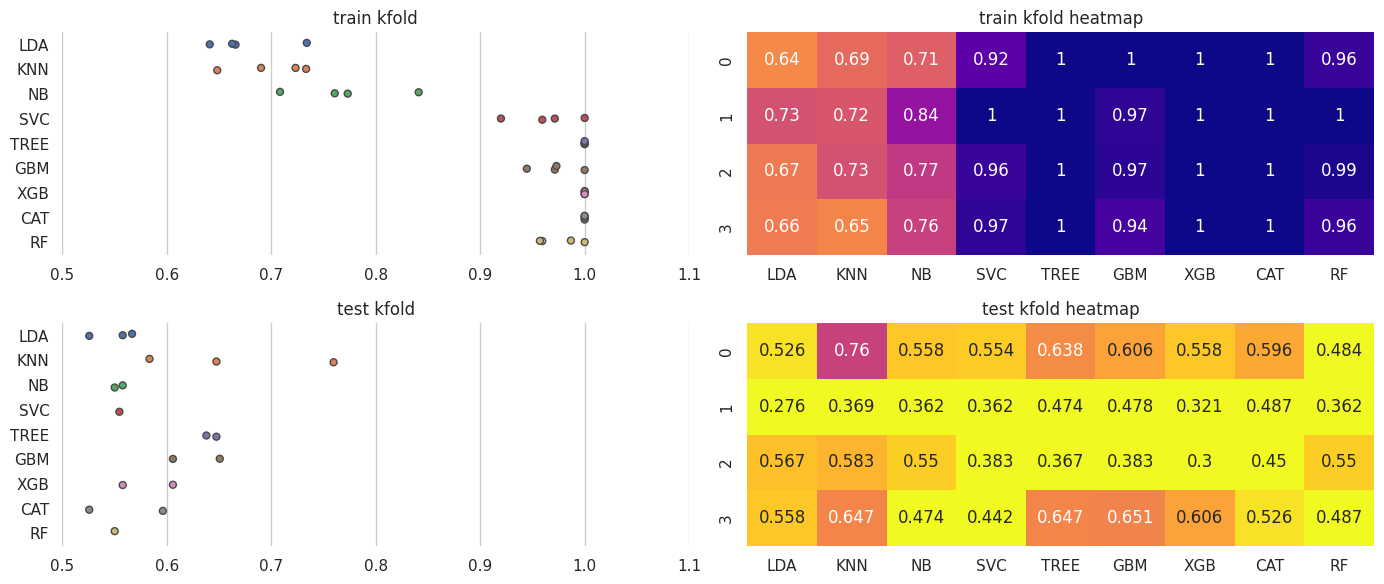

In [ ]:
eval1.fold_plot()

In [ ]:
''' Tree Based Feature Importance '''
# requires evaluation class input w/ at least one of RF, CatBoost & XGB moedls
# models stored in .store_models are required from eval class

class fi:

    def __init__(self,data=None, # evaluation class
                      sort_by='RF', # show most important features
                      max_features=10 # limit unitigs to
                ):

        if(data is None):
            print('Enter Evaluation class w/ CAT,RF,XGB')
        else:
            evals = data
            # check which models are present
            lst_models = list(evals.store_models.keys())
            temp = []
            for i in lst_models:
                if('CAT' in i):
                    temp.append('CAT')
                if('RF' in i):
                    temp.append('RF')
                if('XGB' in i):
                    temp.append('XGB')

            # input contains gscv data
            if('GS' in lst_models[0]):
                self.gs_id = True
            else:
                self.gs_id = False

        self.lst_tree_models = list(set(temp))

        self.evals = data  # evaluation class
        self.lst_Seqs = []  # list of important unitigs
        self.max_features = max_features # show top n features
        self.sort_by = sort_by # sort by particualr model fi, other mods show this index only
        self.abr_feat = False # activate if unitig names are too big for figure

    # Compile all Tree based feature importance results
    def get(self):

        # USL scaling
        min_max_scaler = preprocessing.MinMaxScaler()

        # Recall Model & Get Feature Importance from data class
        # unless gridsearched, all kfolds are the same model

        ii=-1
        # if randomforest models are present
        if('RF' in self.lst_tree_models):

            if(self.gs_id):

                # fold names
                tlst_models = [f'GS_RF_{i}' for i in range(0,self.evals.nfold)]

                # stack all fold results
                for kfold_id in tlst_models:
                    ii+=1
                    rf_model = self.evals.store_models[kfold_id]
                    imp_rf = rf_model.feature_importances_
                    rf_sc = min_max_scaler.fit_transform(imp_rf[:,None])
                    ldf = pd.DataFrame(rf_sc,index=self.evals.X.columns,columns=[kfold_id])
                    if(ii is 0):
                        df = ldf.copy()
                    else:
                        df = pd.concat([df,ldf],axis=1)

            else:

                ii+=1
                rf_model = self.evals.store_models['RF_1']
                imp_rf = rf_model.feature_importances_
                rf_sc = min_max_scaler.fit_transform(imp_rf[:,None])
                ldf = pd.DataFrame(rf_sc,index=self.evals.X.columns,columns=['RF'])
                if(ii is 0):
                    df = ldf.copy()
                else:
                    df = pd.concat([df,ldf],axis=1)

        # if catboost models are present
        if('CAT' in self.lst_tree_models):

            if(self.gs_id):

                # fold names
                tlst_models = [f'GS_CAT_{i}' for i in range(0,self.evals.nfold)]

                # stack all fold results
                for kfold_id in tlst_models:
                    ii+=1
                    cb_model = self.evals.store_models[kfold_id]
                    imp_cb = cb_model.get_feature_importance()
                    cb_sc = min_max_scaler.fit_transform(imp_cb[:,None])
                    ldf = pd.DataFrame(cb_sc,index=self.evals.X.columns,columns=[kfold_id])
                    if(ii is 0):
                        df = ldf.copy()
                    else:
                        df = pd.concat([df,ldf],axis=1)

            else:
                ii+=1
                cb_model = self.evals.store_models['CAT_1']
                imp_cb = cb_model.get_feature_importance()
                cb_sc = min_max_scaler.fit_transform(imp_cb[:,None])
                ldf = pd.DataFrame(cb_sc,index=self.evals.X.columns,columns=['CB'])
                if(ii is 0):
                    df = ldf.copy()
                else:
                    df = pd.concat([df,ldf],axis=1)


        if('XGB' in self.lst_tree_models):

            if(self.gs_id):

                # fold names
                tlst_models = [f'GS_XGB_{i}' for i in range(0,self.evals.nfold)]

                # stack all fold results
                for kfold_id in tlst_models:
                    ii+=1
                    xg_model = self.evals.store_models[kfold_id]
                    imp_xg = xg_model.feature_importances_
                    xg_sc = min_max_scaler.fit_transform(imp_xg[:,None])
                    ldf = pd.DataFrame(xg_sc,index=self.evals.X.columns,columns=[kfold_id])
                    if(ii is 0):
                        df = ldf.copy()
                    else:
                        df = pd.concat([df,ldf],axis=1)

            else:

                ii+=1
                xg_model = self.evals.store_models['XGB_1']
                imp_xg = xg_model.feature_importances_
                xg_sc = min_max_scaler.fit_transform(imp_xg[:,None])
                ldf = pd.DataFrame(rf_sc,index=self.evals.X.columns,columns=['XGB'])

                if(ii is 0):
                    df = ldf.copy()
                else:
                    df = pd.concat([df,ldf],axis=1)

        # change to abbrev if names are too long to display
        if(self.abr_feat):
            self.evals.col_trans(0)

        # Sort by one of the available columns
        df.sort_values(by=self.sort_by,ascending=False,inplace=True)

        if(self.abr_feat):
                self.evals.col_trans(1)

        # show only most critical features in FI
        subset = df[:self.max_features]

#       Store the most important features
        for i in subset.index.tolist():
            self.lst_Seqs.append(Seq(i))

        # Plot features
        fig = px.bar(subset,orientation='h')
        fig.update_traces(width=0.5)
        fig.update_layout(height=400,template='plotly_white',
                          title=f"<b>FEATURE IMPORTANCE</b> | Sorted by {self.sort_by}()")
        fig.show()

In [ ]:
crit_unitigs = fi(data=eval1,sort_by='CB')
crit_unitigs.get()

In [ ]:
print(crit_unitigs.evals.store_models.keys())

dict_keys(['LDA_0', 'LDA_1', 'LDA_2', 'LDA_3', 'KNN_0', 'KNN_1', 'KNN_2', 'KNN_3', 'NB_0', 'NB_1', 'NB_2', 'NB_3', 'SVC_0', 'SVC_1', 'SVC_2', 'SVC_3', 'TREE_0', 'TREE_1', 'TREE_2', 'TREE_3', 'GBM_0', 'GBM_1', 'GBM_2', 'GBM_3', 'XGB_0', 'XGB_1', 'XGB_2', 'XGB_3', 'CAT_0', 'CAT_1', 'CAT_2', 'CAT_3', 'RF_0', 'RF_1', 'RF_2', 'RF_3'])


In [ ]:
crit_unitigs.lst_Seqs

[Seq('u5'),
 Seq('u10'),
 Seq('u7'),
 Seq('u13'),
 Seq('u15'),
 Seq('u17'),
 Seq('u6'),
 Seq('u0'),
 Seq('u14'),
 Seq('u9')]

In [ ]:
# Show default parameters used in catboost model
eval1.store_models['CAT_0'].get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 10,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 1,
 'use_best_model': False,
 'class_names': [0, 1],
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate': 0.23258699476718905,
 'score

In [ ]:
!pip install catboost==1.0.6

ERROR: Could not find a version that satisfies the requirement catboost==1.0.6 (from versions: 1.2, 1.2.1, 1.2.1.1, 1.2.2, 1.2.3, 1.2.5, 1.2.6, 1.2.7, 1.2.8)
ERROR: No matching distribution found for catboost==1.0.6


In [ ]:
# Define Grid used in Cross Validation
params = {'n_estimators': [10, 25, 40],
          'learning_rate': [0.01, 0.05, 0.5]}

# Define Model (name, model, param grid)
models = [('CAT', CatBoostClassifier(silent=True, task_type="CPU"), params)]

# Get Dataset Features
case2 = get_unitigs()
case2.get_case('cip_sr')

# Use original class_eval that expects list of tuples
eval2 = class_eval(data=case,
                   models=models)
eval2.gscv()

Target Antibiotic: cip_sr
Metadata df: (3786, 30)
Metadata df after na() removal: (3088, 30)

Combining Metadata & Unitigs
Unitig Matrix (+target): (3088, 8874)

kfold 0
Train Score: 0.9861 - Test Score: 0.6795
Best hyperparameters for this fold
{'learning_rate': 0.05, 'n_estimators': 10}
Test : Confusion matrix Fold 0
[[9 4]
 [4 8]]

kfold 1
Train Score: 1.0 - Test Score: 0.5256
Best hyperparameters for this fold
{'learning_rate': 0.5, 'n_estimators': 10}
Test : Confusion matrix Fold 1
[[8 4]
 [8 5]]

kfold 2
Train Score: 1.0 - Test Score: 0.5333
Best hyperparameters for this fold
{'learning_rate': 0.05, 'n_estimators': 25}
Test : Confusion matrix Fold 2
[[7 8]
 [4 6]]

kfold 3
Train Score: 1.0 - Test Score: 0.5224
Best hyperparameters for this fold
{'learning_rate': 0.5, 'n_estimators': 10}
Test : Confusion matrix Fold 3
[[7 5]
 [7 6]]

 CAT - Test Mean Score: 0.5652


In [ ]:
print(eval2.store_models.keys())  # Check which models are present

dict_keys(['GS_CAT_0', 'GS_CAT_1', 'GS_CAT_2', 'GS_CAT_3'])


In [ ]:
crit_unitigs = fi(data=eval2, sort_by='GS_CAT_0')
crit_unitigs.get()

In [ ]:
crit_unitigs.lst_Seqs

[Seq('u14'),
 Seq('u17'),
 Seq('u1'),
 Seq('u16'),
 Seq('u0'),
 Seq('u13'),
 Seq('u9'),
 Seq('u7'),
 Seq('u19'),
 Seq('u15')]

In [ ]:
case = get_unitigs(base_path='/kaggle/input/gono-unitigs')
case.get_case('cip_sr')

print(case.X.groupby('cip_sr')['GTGCGACAGCAAAGTCCAAACCAGCGTCCCCGCC'].mean())
print(case.X.groupby('cip_sr')['GCGCAGCCGCAAATCTTGTTTTCCCATTCCGCC'].mean())
print(case.X.groupby('cip_sr')['AAATTGCGGATCGATGCGCGAAGGGTCGAATGC'].mean())
print(case.X.groupby('cip_sr')['GGCATCCCGAAGCCGAATACGGCAACGGCAAGCG'].mean())


Target Antibiotic: cip_sr
Metadata df: (3786, 30)
Metadata df after na() removal: (3088, 30)

Combining Metadata & Unitigs
Unitig Matrix (+target): (3088, 8874)
cip_sr
0.0    0.958434
1.0    0.044818
Name: GTGCGACAGCAAAGTCCAAACCAGCGTCCCCGCC, dtype: float64
cip_sr
0.0    0.933735
1.0    0.010504
Name: GCGCAGCCGCAAATCTTGTTTTCCCATTCCGCC, dtype: float64
cip_sr
0.0    0.046386
1.0    0.778011
Name: AAATTGCGGATCGATGCGCGAAGGGTCGAATGC, dtype: float64
cip_sr
0.0    0.070482
1.0    0.220588
Name: GGCATCCCGAAGCCGAATACGGCAACGGCAAGCG, dtype: float64


In [ ]:
''' Define Models used for Testing '''
models = []
models.append(('SVC',SVC(kernel = 'linear')))

# Get case; (Dataset Feature Class)
case = get_unitigs()
case.get_case('cip_sr')

# Standard KFOLD evaluation
eval_svc1 = class_eval(data=case, # input the case class
                   nfold = 4, # 4 fold kfold
                   models=models) # global models tuple list)

# Evaluate kfold using selected models
eval_svc1.cv(type_id='kfold')  # standard kfold evaluation

Target Antibiotic: cip_sr
Metadata df: (3786, 30)
Metadata df after na() removal: (3088, 30)

Combining Metadata & Unitigs
Unitig Matrix (+target): (3088, 8874)
type_id set to: kfold
SVC - Test Mean Score: 0.9294 - Total Time: 65.3273


In [ ]:
''' Function plots & returns highest weighted features '''
# for SVC linear covariance function model in SQ sequence format

def fi_svc(classifier, feature_names, top_features=5,verbose=False):

    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

    # plt.title("Feature Importances (Support Vector Machine) - Ciprofloxacin Resistance", y=1.08)
    colors = ['crimson' if c < 0 else 'cornflowerblue' for c in coef[top_coefficients]]
    feature_names = np.array(feature_names)
    lser = pd.Series(data=coef[top_coefficients],index=feature_names[top_coefficients])
    fig = px.bar(lser,orientation='h')
    fig.update_traces(width=0.5)
    fig.update_layout(height=350,template='plotly_white',showlegend=False,
                        title=f"<b>FEATURE IMPORTANCE</b> | SVC")
    fig.show()

    # if we print the unitigs, we can then look at what genes they relate to
    top_negative_coefficients = np.argsort(coef)[:5]
    neg_predictors = np.asarray(feature_names)[top_negative_coefficients]
    top_positive_coefficients = np.argsort(coef)[-5:]
    pos_predictors = np.asarray(feature_names)[top_positive_coefficients]
    if(verbose):
        print("Top negative predictors: ",neg_predictors)
        print("Top positive predictors: ",pos_predictors)

    # Store the most important features
    top_negSeq = []; top_posSeq = []
    for i in range(0,top_features):
        top_negSeq.append(Seq(neg_predictors[i]))
        top_posSeq.append(Seq(pos_predictors[i]))

    return top_negSeq, top_posSeq

In [ ]:
eval_svc1.store_models

{'SVC_0': SVC(kernel='linear'),
 'SVC_1': SVC(kernel='linear'),
 'SVC_2': SVC(kernel='linear'),
 'SVC_3': SVC(kernel='linear')}

In [ ]:
neg_predictors,pos_predictors = fi_svc(eval_svc1.store_models['SVC_3'], list(eval_svc1.X.columns))

In [ ]:
# return list of sequences list ordered from most to least important
neg_predictors

[Seq('AACAGATGCGCCGCGAACAGGCGTTCAGACGGG'),
 Seq('GTGCAGCGTGTTGTCGAGGTCGAACAGCCACA'),
 Seq('GCGCAGCCGCAAATCTTGTTTTCCCATTCCGCC'),
 Seq('CCCGGACAAACGGCACTAAATAGAAATAGTGCTTTCTCTATTT'),
 Seq('GCCACGCCGAGAAACACACCAAAAACGCACC')]

In [ ]:
# return list of sequences ordered from least to most important
pos_predictors

[Seq('CGGATTTTTTGGCGGCTGCCGCAGCCGCGCGCAAG'),
 Seq('AGACGGCATTTCGACAAGGAATACGATGGAACTGC'),
 Seq('GCGTGCGGGTAGTCTTGCGTGTCGATGCCGAC'),
 Seq('AATGAGGCACATGCAGGGCCTTGAAGCGCAAT'),
 Seq('TGCCAATGCCGAAGCCGCTGCCACCGATACTCTGAACATCTACAAC')]

### **<span style='color:#E888BB'>SVC OPTIMISED MODEL </span>**
- The linear covariance function model performed a little worse than those tested in the previous section
- Let's see if we can optimise the model a little bit & check if the same features will remain the most important in the model
- Let's try a variation in the **gamma** hyperparameter for the search grid to keep things quite simple

In [ ]:
svm_params = {
    'C': [0.01],
    'gamma': [1e-06, 1e-05],
    'kernel': ['linear']
}

# Define Model (just the one)
svm = SVC(class_weight='balanced')
models = []
models.append(('SVM',svm,svm_params))

# Get Dataset Features
case = get_unitigs()
case.get_case('cip_sr')

eval_svc2 = class_eval(data=case,
                   models=models)
eval_svc2.gscv()

Target Antibiotic: cip_sr
Metadata df: (3786, 30)
Metadata df after na() removal: (3088, 30)

Combining Metadata & Unitigs
Unitig Matrix (+target): (3088, 8874)

kfold 0
Train Score: 0.9855 - Test Score: 0.9705
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Test : Confusion matrix Fold 0
[[397  14]
 [  9 352]]

kfold 1
Train Score: 0.9924 - Test Score: 0.9048
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Test : Confusion matrix Fold 1
[[373  65]
 [ 14 320]]

kfold 2
Train Score: 0.9849 - Test Score: 0.9725
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Test : Confusion matrix Fold 2
[[445   0]
 [ 18 309]]

kfold 3
Train Score: 0.9868 - Test Score: 0.9609
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Test : Confusion matrix Fold 3
[[359   7]
 [ 24 382]]

 SVM - Test Mean Score: 0.9522


In [ ]:
eval_svc2.store_models

{'GS_SVM_0': SVC(C=0.01, class_weight='balanced', gamma=1e-06, kernel='linear'),
 'GS_SVM_1': SVC(C=0.01, class_weight='balanced', gamma=1e-06, kernel='linear'),
 'GS_SVM_2': SVC(C=0.01, class_weight='balanced', gamma=1e-06, kernel='linear'),
 'GS_SVM_3': SVC(C=0.01, class_weight='balanced', gamma=1e-06, kernel='linear')}

In [ ]:
neg_predictors,pos_predictors = fi_svc(eval_svc2.store_models['GS_SVM_0'], list(eval_svc2.X.columns))

In [ ]:
# return list of sequences list ordered from most to least important
neg_predictors

[Seq('GTGCGACAGCAAAGTCCAAACCAGCGTCCCCGCC'),
 Seq('GCGCAGCCGCAAATCTTGTTTTCCCATTCCGCC'),
 Seq('GCCGAAATATTCCGTCAGCAGTTTTTCCCCC'),
 Seq('AACAGATGCGCCGCGAACAGGCGTTCAGACGGG'),
 Seq('AGAACATTGCGCCTGTTTATGACACAATTGGCAATAAAAAA')]

In [ ]:
# return list of sequences ordered from least to most important
pos_predictors

[Seq('CGTCTGAAAAAACACAATATCGATGTCTATATTATGAGCGGCGA'),
 Seq('ATGACCGAACAACACTTTACCGAACAAATCAAATCCCTAATCGACAGCTTAAAAACCAT'),
 Seq('CATAAAGTTTCCTTGTTTTATTGAAATATAAATCG'),
 Seq('ATCCGGCAAAAAACGGAGGCGGCAGGAAACA'),
 Seq('TTACCCGTAATTTCAAAAATATCCCTTACGCCG')]

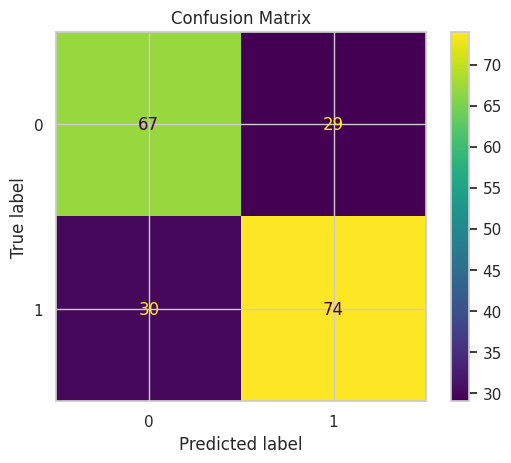

In [ ]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# Simulate genomic-like data for demonstration
X, y = make_classification(n_samples=1000, n_features=200, n_informative=50, n_classes=2, random_state=42)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()


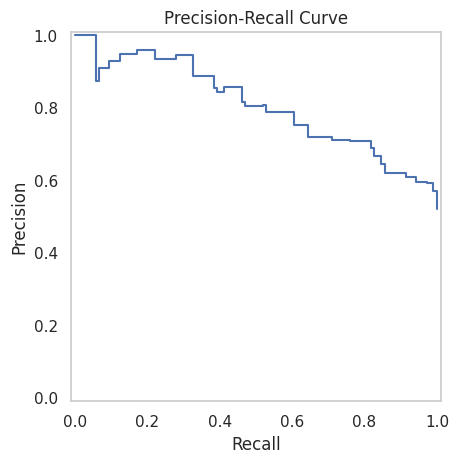

In [ ]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (resistant = 1)
y_scores = model.predict_proba(X_test)[:, 1]

# Compute precision and recall values
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Plot
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.grid()
plt.savefig("precision_recall_curve.png")
plt.show()

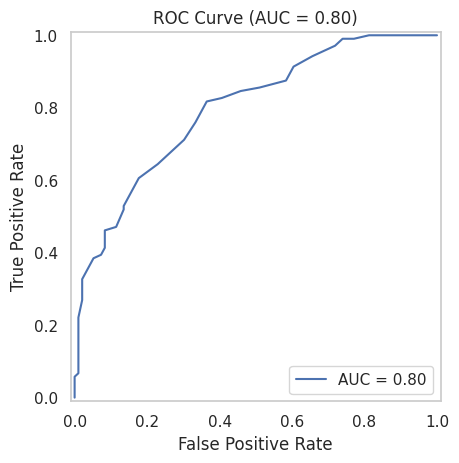

In [ ]:
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (resistant = 1)
y_scores = model.predict_proba(X_test)[:, 1]

# Compute FPR (False Positive Rate), TPR (True Positive Rate), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Compute AUC (Area Under the Curve)
auc_score = roc_auc_score(y_test, y_scores)

# Plot ROC Curve
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score).plot()
plt.title(f"ROC Curve (AUC = {auc_score:.2f})")
plt.grid()
plt.savefig("roc_curve.png")
plt.show()